# Importing Libraries

In [1]:
# Importing all libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import tensorflow as tf
import numpy as np
import hashlib
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Change directory to 'DATASCI207_FinalProject'
os.chdir('/content/drive/My Drive/DATASCI207_FinalProject')

# Import Training, Validation, and Testing Datasets:

In [4]:
# Load the Pre-Processed Training Data:
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')

# Load the Pre-Processed Validation Data:
X_val = np.load('X_val.npy')
Y_val = np.load('Y_val.npy')

# Load the Pre-Processed Testing Data:
X_test = np.load('X_test.npy')
Y_test = np.load('Y_test.npy')

# Building a More Complex CNN
We have demonstrated that our baseline model has resulted in producing relatively good results (~88% validation accuracy) for our predictions of brain tumors in MRI images. Now, let's continue to build upon this model to try and build a model that has even better results.

We will begin with the baseline model as a foundation, and gradually build upon it with more complexity. In the model below, we have added another Convolutional 2D layer, another MaxPooling layer, and another Dropout layer (keeping all other hyperparameters equivalent).

In [5]:
def build_complex_model_2_layers(filters=12, kernel_size=(4,4), strides=(1,1), max_pool_size=(2,2), dropout=0.3):
  '''Function to create and compile a more complex CNN model. The model includes
     two Conv2D layers, two MaxPooling2D layers, and one Dense layer. Used for
     hyperparameter tuning.

     Input: hyperparameters, including: number of filters, kernel size, stride size
     max pooling size, dropout rate, and number of epochs.

     Output: compiled model with performance results.'''

  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    #monitor the validation accuracy
    verbose=1,
    #set to 4
    patience=4,
    #looks for the maximum value of validation accuracy
    mode='max',
    #After stopping, it goes back to the best model weights it had during training
    restore_best_weights=True
  )

  model = tf.keras.Sequential([
    # First Conv2D layer:
    tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(224, 224, 3), name='2_Layer_CNN_Conv_1'),

    # First MaxPooling2D layer:
    tf.keras.layers.MaxPooling2D(max_pool_size),

    # First Dropout layer:
    tf.keras.layers.Dropout(dropout),

    # Second Conv2D layer:
    tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', name='2_Layer_CNN_Conv_2'),

    # Second MaxPooling2D layer:
    tf.keras.layers.MaxPooling2D(max_pool_size),

    # Second Dropout layer:
    tf.keras.layers.Dropout(dropout),

    # Flatten and Output layers:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
  ])

  # Compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss='sparse_categorical_crossentropy', #labels are not one hot encoded so i used sparse categorical crossentropy
               metrics=['accuracy'])

  return model, early_stopping

### Fitting and Running the 2-Layer Model:

In [6]:
model_2_layers, early_stopping = build_complex_model_2_layers()

Epoch 1/20
259/259 [==============================] - 50s 188ms/step - loss: 0.8138 - accuracy: 0.6643 - val_loss: 0.6341 - val_accuracy: 0.7190
Epoch 2/20
259/259 [==============================] - 45s 175ms/step - loss: 0.4488 - accuracy: 0.8261 - val_loss: 0.6688 - val_accuracy: 0.7408
Epoch 3/20
259/259 [==============================] - 46s 179ms/step - loss: 0.3282 - accuracy: 0.8803 - val_loss: 0.4569 - val_accuracy: 0.8204
Epoch 4/20
259/259 [==============================] - 47s 180ms/step - loss: 0.2505 - accuracy: 0.9076 - val_loss: 0.5590 - val_accuracy: 0.8132
Epoch 5/20
259/259 [==============================] - 46s 178ms/step - loss: 0.2074 - accuracy: 0.9202 - val_loss: 0.3877 - val_accuracy: 0.8646
Epoch 6/20
259/259 [==============================] - 46s 177ms/step - loss: 0.1531 - accuracy: 0.9461 - val_loss: 0.4488 - val_accuracy: 0.8552
Epoch 7/20
259/259 [==============================] - 45s 175ms/step - loss: 0.1161 - accuracy: 0.9560 - val_loss: 0.4874 - val_ac

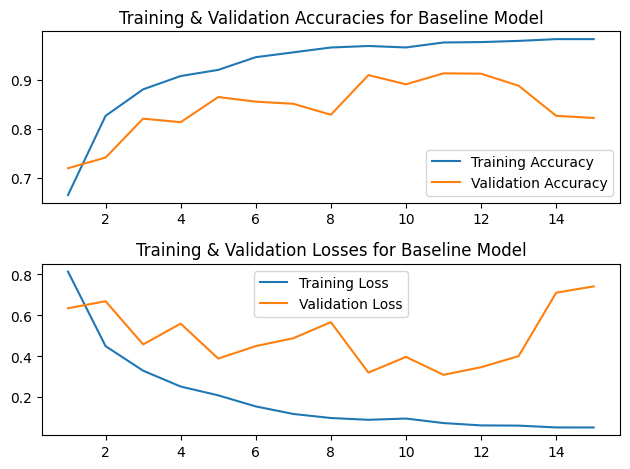

In [7]:
# Run for 20 epochs:
epochs = 20

# Fit the model:
model_2_layers_fit = model_2_layers.fit(
      x=X_train,
      y=Y_train,
      epochs=epochs,
      validation_data=(X_val, Y_val),
      callbacks=[early_stopping]
)

# Store accuracy and loss values:
model_acc = model_2_layers_fit.history['accuracy']
model_val_acc = model_2_layers_fit.history['val_accuracy']

model_loss = model_2_layers_fit.history['loss']
model_val_loss = model_2_layers_fit.history['val_loss']

model_epochs = np.arange(1, len(model_acc) + 1)

# Calculate the number of epochs for the x-axis:
num_epochs = np.arange(1, len(model_acc) + 1)

fig, ax = plt.subplots(nrows=2, ncols=1)

# Plot the model accuracies
ax[0].plot(num_epochs, model_acc, label='Training Accuracy')
ax[0].plot(num_epochs, model_val_acc, label='Validation Accuracy')

ax[0].set_title('Training & Validation Accuracies for Baseline Model')
ax[0].legend()

ax[1].plot(num_epochs, model_loss, label='Training Loss')
ax[1].plot(num_epochs, model_val_loss, label='Validation Loss')

ax[1].set_title('Training & Validation Losses for Baseline Model')
ax[1].legend()

plt.tight_layout()
plt.show()

### Adding another Convolutional Layer
Continuing to build complexity, let's add another convolutional layer, max pooling layer, and dropout layer to our model and compare the results.

In [8]:
def build_complex_model_3_layers(filters=12, kernel_size=(4,4), strides=(1,1), max_pool_size=(2,2), dropout=0.3):
  '''Function to create and compile a more complex CNN model. The model includes
     three Conv2D layers, three MaxPooling2D layers, and one Dense layer. Used for
     hyperparameter tuning.

     Input: hyperparameters, including: number of filters, kernel size, stride size
     max pooling size, dropout rate, and number of epochs.

     Output: compiled model with performance results.'''

  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    #monitor the validation accuracy
    verbose=1,
    #set to 4
    patience=4,
    #looks for the maximum value of validation accuracy
    mode='max',
    #After stopping, it goes back to the best model weights it had during training
    restore_best_weights=True
  )

  model = tf.keras.Sequential([
    # First Conv2D layer:
    tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(224, 224, 3), name='conv_1'),

    # First MaxPooling2D layer:
    tf.keras.layers.MaxPooling2D(max_pool_size),

    # First Dropout layer:
    tf.keras.layers.Dropout(dropout),

    # Second Conv2D layer:
    tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', name='conv_2'),

    # Second MaxPooling2D layer:
    tf.keras.layers.MaxPooling2D(max_pool_size),

    # Second Dropout layer:
    tf.keras.layers.Dropout(dropout),

    # Third Conv2D layer:
    tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', name='conv_3'),

    # Third MaxPooling2D layer:
    tf.keras.layers.MaxPooling2D(max_pool_size),

    # Third Dropout layer:
    tf.keras.layers.Dropout(dropout),

    # Flatten and Output layers:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
  ])

  # Compile the model:
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss='sparse_categorical_crossentropy', #labels are not one hot encoded so i used sparse categorical crossentropy
               metrics=['accuracy'])

  return model, early_stopping

### Fitting and Running the 3-layer Model:

In [9]:
model_3_layers, early_stopping = build_complex_model_3_layers()

Epoch 1/20
259/259 [==============================] - 53s 203ms/step - loss: 0.8489 - accuracy: 0.6448 - val_loss: 0.7381 - val_accuracy: 0.6951
Epoch 2/20
259/259 [==============================] - 51s 196ms/step - loss: 0.5439 - accuracy: 0.7888 - val_loss: 0.8386 - val_accuracy: 0.6322
Epoch 3/20
259/259 [==============================] - 51s 196ms/step - loss: 0.4459 - accuracy: 0.8298 - val_loss: 0.7491 - val_accuracy: 0.6517
Epoch 4/20
259/259 [==============================] - 51s 197ms/step - loss: 0.3746 - accuracy: 0.8588 - val_loss: 1.0593 - val_accuracy: 0.5793
Epoch 5/20
259/259 [==============================] - 51s 196ms/step - loss: 0.3252 - accuracy: 0.8758 - val_loss: 0.5102 - val_accuracy: 0.7799
Epoch 6/20
259/259 [==============================] - 50s 192ms/step - loss: 0.2954 - accuracy: 0.8890 - val_loss: 0.6822 - val_accuracy: 0.7053
Epoch 7/20
259/259 [==============================] - 50s 192ms/step - loss: 0.2564 - accuracy: 0.9041 - val_loss: 0.5186 - val_ac

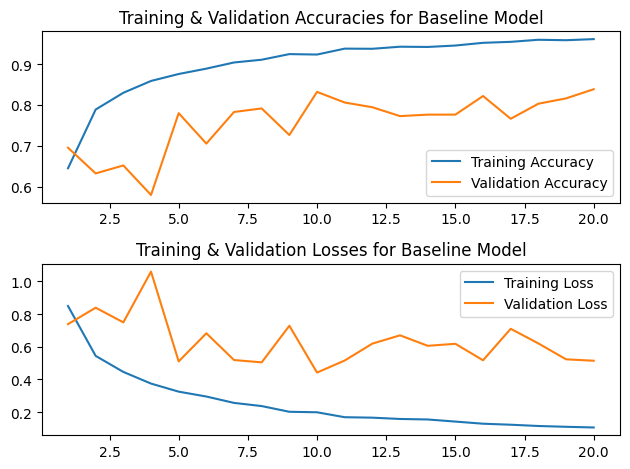

In [10]:
# Run for 20 epochs:
epochs = 20

# Fit the model:
model_3_layers_fit = model_3_layers.fit(
      x=X_train,
      y=Y_train,
      epochs=epochs,
      validation_data=(X_val, Y_val),
      callbacks=[early_stopping]
  )

# Store accuracy and loss values:
model_acc = model_3_layers_fit.history['accuracy']
model_val_acc = model_3_layers_fit.history['val_accuracy']

model_loss = model_3_layers_fit.history['loss']
model_val_loss = model_3_layers_fit.history['val_loss']

# Calculate the number of epochs for the x-axis:
num_epochs = np.arange(1, len(model_acc) + 1)

fig, ax = plt.subplots(nrows=2, ncols=1)

# Plot the model accuracies
ax[0].plot(num_epochs, model_acc, label='Training Accuracy')
ax[0].plot(num_epochs, model_val_acc, label='Validation Accuracy')

ax[0].set_title('Training & Validation Accuracies for Baseline Model')
ax[0].legend()

ax[1].plot(num_epochs, model_loss, label='Training Loss')
ax[1].plot(num_epochs, model_val_loss, label='Validation Loss')

ax[1].set_title('Training & Validation Losses for Baseline Model')
ax[1].legend()

plt.tight_layout()
plt.show()

### Experimenting with Number of Filters
The model with 2 Convolutional layers appears to perform better than that with 3-layers. This is likely due to the fact that adding more complexity into the model with a smaller dataset (~8,000) images, results in a higher degree of overfitting.

Experimenting with the filter size for the 2-layer model:

Epoch 1/20
259/259 [==============================] - 49s 188ms/step - loss: 0.7546 - accuracy: 0.6900 - val_loss: 0.5803 - val_accuracy: 0.7741
Epoch 2/20
259/259 [==============================] - 47s 180ms/step - loss: 0.4517 - accuracy: 0.8226 - val_loss: 0.5684 - val_accuracy: 0.7828
Epoch 3/20
259/259 [==============================] - 46s 178ms/step - loss: 0.3308 - accuracy: 0.8812 - val_loss: 0.3927 - val_accuracy: 0.8595
Epoch 4/20
259/259 [==============================] - 46s 178ms/step - loss: 0.2323 - accuracy: 0.9135 - val_loss: 0.3838 - val_accuracy: 0.8668
Epoch 5/20
259/259 [==============================] - 46s 177ms/step - loss: 0.1871 - accuracy: 0.9303 - val_loss: 0.3549 - val_accuracy: 0.8885
Epoch 6/20
259/259 [==============================] - 46s 179ms/step - loss: 0.1461 - accuracy: 0.9496 - val_loss: 0.3431 - val_accuracy: 0.8943
Epoch 7/20
259/259 [==============================] - 46s 176ms/step - loss: 0.1148 - accuracy: 0.9606 - val_loss: 0.4801 - val_ac

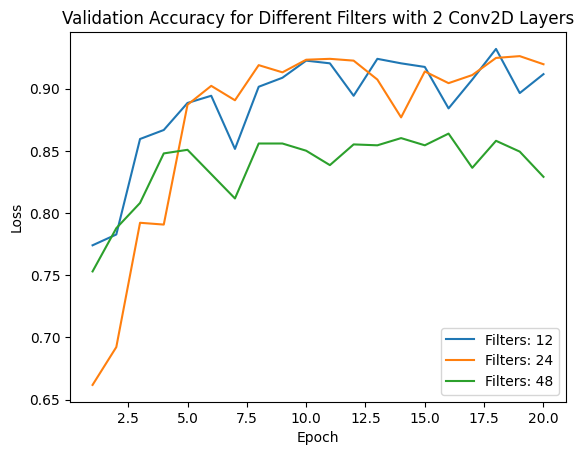

In [12]:
epochs = [20]
filters = [12, 24, 48]

for epoch in epochs:
  for filter in filters:

    model2, early_stopping = build_complex_model_2_layers(filters=filter)

    model2_fit = model2.fit(
      x=X_train,
      y=Y_train,
      epochs=epoch,
      validation_data=(X_val, Y_val)
    )

    model2_acc = model2_fit.history['accuracy']
    model2_val_acc = model2_fit.history['val_accuracy']
    model2_epochs = np.arange(1, len(model2_acc) + 1)

    plt.plot(model2_epochs, model2_val_acc, label=f'Filters: {filter}')

    # Add labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Accuracy for Different Filters with 2 Conv2D Layers')
    plt.legend();

We find that more filters actually corresponds to worse performance. Again, this is likely due to the fact that increasing complexity also increases the degree of overfitting within a relatively small dataset. Moving forward, we will continue with 12 filters to reduce complexity while maintaining the best results.

In [ ]:
# Save the 2-layer model:
model_2_layers.save('/content/drive/My Drive/DATASCI207_FinalProject/model_2_layers.keras')

In [ ]:
# Save the 3-layer model:
model_3_layers.save('/content/drive/My Drive/DATASCI207_FinalProject/model_3_layers.keras')